# Introduction
This project aims to draw the connection between transportation crashes occurred in the city of San Francisco and the historical weather forecasts in the same area. I will do so by examining the temperature, windspeed, humidity, weather condition, and road surface condition against the collision severity and fatalities. There is also the possibility that the vehicle type may be relevant. 

The expectation is that inclement weather such as heavy rain or snow may lead to higher traffic accidents in certain areas of the city. 

# Data Preprocessing and Wrangling
## Import libraries

In [249]:
import requests
import json
import pandas as pd
from datetime import datetime   
import time
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import dates as dates
import seaborn as sns
import geopandas as gpd
import zipfile
# Format and style
%matplotlib inline


In [195]:
with zipfile.ZipFile('tl_2017_06075_roads.zip', 'r') as zip_ref:
    zip_ref.extractall('shapefiles')
# Import shapefile as GeoDataFrame
geo_df = gpd.read_file('shapefiles/tl_2017_06075_roads.shp')
df_sf = merged[['collision_severity', 'tb_latitude', 'tb_longitude']]

## Dataset 1


This dataset contains all crashes resulting in an injury in the City of San Francisco. Fatality year-to-date crash data is obtained from the Office of the Chief Medical Examiner (OME) death records, and only includes those cases that meet the San Francisco Vision Zero Fatality Protocol maintained by the San Francisco Department of Public Health (SFDPH), San Francisco Police Department (SFPD), and San Francisco Municipal Transportation Agency (SFMTA). Injury crash data is obtained from SFPD’s Interim Collision System for 2018 through the current year-to-date, Crossroads Software Traffic Collision Database (CR) for years 2013-2017 and the Statewide Integrated Transportation Record System (SWITRS) maintained by the California Highway Patrol for all years prior to 2013. Only crashes with valid geographic information are mapped. All geocodable crash data is represented on the simplified San Francisco street centerline model maintained by the Department of Public Works (SFDPW). Collision injury data is queried and aggregated on a quarterly basis. Crashes occurring at complex intersections with multiple roadways are mapped onto a single point and injury and fatality crashes occurring on highways are excluded.



Additional information: https://data.sfgov.org/Public-Safety/Traffic-Crashes-Resulting-in-Injury/ubvf-ztfx

In [254]:
Collision_API1 = "https://data.sfgov.org/resource/ubvf-ztfx.json"
resp1 = requests.get(Collision_API1)

# We transform the returned JSON answer from the API into a Python dictionary object
results = json.loads(resp1.text)

#create dataframe from list of dictionary
df = pd.DataFrame(results)

#View available columns
df.columns

Index(['id', 'unique_id', 'cnn_intrsctn_fkey', 'case_id_pkey', 'tb_latitude',
       'tb_longitude', 'geocode_source', 'geocode_location',
       'collision_datetime', 'collision_date', 'collision_time',
       'accident_year', 'month', 'day_of_week', 'time_cat', 'juris',
       'officer_id', 'reporting_district', 'beat_number', 'primary_rd',
       'secondary_rd', 'distance', 'direction', 'weather_1', 'weather_2',
       'collision_severity', 'type_of_collision', 'mviw', 'ped_action',
       'road_surface', 'road_cond_1', 'road_cond_2', 'lighting',
       'control_device', 'intersection', 'vz_pcf_code', 'vz_pcf_group',
       'vz_pcf_description', 'vz_pcf_link', 'number_killed', 'number_injured',
       'street_view', 'dph_col_grp', 'dph_col_grp_description', 'party1_type',
       'party1_dir_of_travel', 'party1_move_pre_acc', 'party2_type',
       'party2_dir_of_travel', 'party2_move_pre_acc', 'point',
       'data_loaded_at', ':@computed_region_jwn9_ihcz',
       ':@computed_region_

In [255]:
#identify collumns with too much null values
missing_percentages = df.isna().sum().sort_values(ascending = False)/len(df)
col_name = missing_percentages[missing_percentages != 0].index
a = list(col_name)
a.remove('tb_longitude')
a.remove('tb_latitude')

In [256]:
#remove collumns with too much null values
df = df.drop(a,axis=1)

In [257]:
#drop rows with null values in location and time columns
df = df.dropna(subset=['tb_longitude','tb_latitude'])

In [258]:
# create new column with total number of people involved
df['number_killed'] = df['number_killed'].astype('int')
df['number_injured'] = df['number_injured'].astype('int')
df['total_involved'] = df['number_killed']+df['number_injured']
df['total_involved'] = df['total_involved'].astype('int')
df.head(10)

,id,unique_id,cnn_intrsctn_fkey,case_id_pkey,tb_latitude,tb_longitude,geocode_source,geocode_location,collision_datetime,collision_date,...,vz_pcf_description,number_killed,number_injured,dph_col_grp,dph_col_grp_description,party1_type,party1_dir_of_travel,party1_move_pre_acc,data_loaded_at,total_involved
0,vw_geo_sfpd_cr_switrs_all_types_col_cty_union....,15995,23908000.0,130316559,37.7790321327699,-122.401843272924,SFPD-CROSSROADS,CITY STREET,2013-04-18T06:15:00.000,2013-04-18T00:00:00.000,...,Unknown,0,2,AA,Vehicle(s) Only Involved,Driver,Not Stated,Not Stated,2023-01-28T03:30:22.818,2
1,vw_geo_sfpd_cr_switrs_all_types_col_cty_union....,16469,23944000.0,140665164,37.7814995083039,-122.404933346348,SFPD-CROSSROADS,CITY STREET,2014-08-09T22:48:00.000,2014-08-09T00:00:00.000,...,Unsafe speed for prevailing conditions,0,1,AA,Vehicle(s) Only Involved,Driver,East,Proceeding Straight,2023-01-28T03:30:22.857,1
2,vw_geo_sfpd_cr_switrs_all_types_col_cty_union....,10088,24055000.0,160880063,37.7654476084469,-122.413105242334,SFPD-CROSSROADS,CITY STREET,2016-10-29T01:37:00.000,2016-10-29T00:00:00.000,...,Unsafe speed for prevailing conditions,0,1,AA,Vehicle(s) Only Involved,Driver,West,Ran Off Road,2023-01-28T03:30:23.297,1
3,vw_geo_sfpd_cr_switrs_all_types_col_cty_union....,27168,30734000.0,140065570,37.7892643223925,-122.40137549141,SFPD-CROSSROADS,CITY STREET,2014-01-23T02:00:00.000,2014-01-23T00:00:00.000,...,Following too closely prohibited,0,1,CC,Vehicle-Bicycle,Driver,West,Proceeding Straight,2023-01-28T03:30:23.471,1
4,vw_geo_sfpd_cr_switrs_all_types_col_cty_union....,5037,22132000.0,4318561,37.7307329067636,-122.43973734583,SFPD-CROSSROADS,CITY STREET,2009-07-08T16:26:00.000,2009-07-08T00:00:00.000,...,Failure to stop at STOP sign,0,1,CC,Vehicle-Bicycle,Driver,Not Stated,Making Right Turn,2023-01-28T03:30:23.522,1
5,vw_geo_sfpd_cr_switrs_all_types_col_cty_union....,40135,27336000.0,4318607,37.7542121464069,-122.477106597196,SFPD-CROSSROADS,CITY STREET,2009-07-19T15:12:00.000,2009-07-19T00:00:00.000,...,Unsafe speed for prevailing conditions,0,1,AA,Vehicle(s) Only Involved,Driver,East,Ran Off Road,2023-01-28T03:30:23.662,1
6,vw_geo_sfpd_cr_switrs_all_types_col_cty_union....,32191,25301999.999999996,140202584,37.7922214882359,-122.421020117942,SFPD-CROSSROADS,CITY STREET,2014-03-09T17:07:00.000,2014-03-09T00:00:00.000,...,Unsafe starting or backing on highway,0,1,CC,Vehicle-Bicycle,Driver,South,Entering Traffic,2023-01-28T03:30:24.024,1
7,vw_geo_sfpd_cr_switrs_all_types_col_cty_union....,7607,21901000.0,140897464,37.747785879517,-122.425520701618,SFPD-CROSSROADS,CITY STREET,2014-10-23T11:45:00.000,2014-10-23T00:00:00.000,...,Opening door on traffic side when unsafe,0,1,EE,Bicycle-Parked Car,Parked Vehicle,Not Stated,Parked,2023-01-28T03:30:26.149,1
8,vw_geo_sfpd_cr_switrs_all_types_col_cty_union....,9542,23778000.0,140908873,37.7646643174987,-122.404496977122,SFPD-CROSSROADS,CITY STREET,2014-10-27T09:20:00.000,2014-10-27T00:00:00.000,...,Failure to stop at STOP sign,0,1,AA,Vehicle(s) Only Involved,Driver,North,Proceeding Straight,2023-01-28T03:30:26.186,1
9,vw_geo_sfpd_cr_switrs_all_types_col_cty_union....,17396,54188000.0,140941538,37.7672341937665,-122.422111255375,SFPD-CROSSROADS,CITY STREET,2014-11-06T18:55:00.000,2014-11-06T00:00:00.000,...,Unsafe speed for prevailing conditions,0,1,CC,Vehicle-Bicycle,Bicyclist,South,Passing Other Vehicle,2023-01-28T03:30:26.291,1


In [259]:
#Save sample json file as checkpoint
df.to_json('Collision.json',orient='records')
#get crash data/checkpoint
crash = json.load(open('Collision.json','r'))

In order to translate the data into a readable format, it was loaded, into Pandas Data Frames. Upon closer inspection, many of the features from the original dataset 1 have missing data, but luckily many of them were not relevant to the analysis so they were removed promptly. There were cases with missing data in the longitude and latitude features (7%) so these were also removed as we need the data to collect the weather data. An aggregated feature was created afterwards to sum the total the number of casualty and injured in each incident.

## Dataset 2

Historical weather data provided by OpenWeather allow access to hourly weather data at specific points in time. The dataset will be extracted based on latitude and longitude provided from the crash site dataset 

The documentation for this data is https://openweathermap.org/api/one-call-3#history

In [126]:
#Create function to convert time to UNIX timestamp format
def convert_unix(i):
    datetime_obj = datetime.strptime(i,
                                 "%Y-%m-%dT%H:%M:%S.000")
    unix_time = datetime.timestamp(datetime_obj)
    return unix_time

#insert converted data into json file
 
for i in crash:
    bi = int(convert_unix(i['collision_datetime']))
    unix_add = {"unix_dict": bi} 
    i.update(unix_add)


In [127]:
query_template = '''https://api.openweathermap.org/data/3.0/onecall/timemachine?lat=%s&lon=%s&dt=%s&appid=%s''' 
API = []
for entry in crash: 
    lat = entry['tb_latitude'] 
    lon = entry['tb_longitude']
    dt = entry['unix_dict'] 
    appid = "503ed749861a1697a1d7ac5455250b08" 
    query_parameters = (lat, lon, dt, appid) 
    Weather_API = query_template % query_parameters 
    API.append(Weather_API)


In [128]:
#request data
weather_json = []

for link in API:
    weather_data = requests.get(link).json()
    ver1 = weather_data['data'][0]
    ver1.update(weather_data)
    ver1.pop('data')
    ver2 = ver1['weather'][0]
    ver2.update(ver1)
    ver2.pop('weather')
    weather_json.append(ver2)
    time.sleep(1)

In [129]:
#convert to dataframe
results_df = pd.DataFrame(weather_json)
results_df.head(10)

,id,main,description,icon,dt,sunrise,sunset,temp,feels_like,pressure,...,dew_point,clouds,wind_speed,wind_deg,wind_gust,lat,lon,timezone,timezone_offset,rain
0,800,Clear,clear sky,01n,1366280100,1366291771,1366339664,284.18,283.27,1023,...,279.73,0,1.03,270,1.03,37.7790,-122.4018,America/Los_Angeles,-25200,NaN
1,802,Clouds,scattered clouds,03d,1407638880,1407590407,1407640209,290.30,290.39,1014,...,288.47,30,5.88,277,NaN,37.7815,-122.4049,America/Los_Angeles,-25200,NaN
2,802,Clouds,scattered clouds,03n,1477719420,1477665085,1477703710,290.21,290.50,1014,...,289.73,25,1.32,180,NaN,37.7654,-122.4131,America/Los_Angeles,-25200,NaN
3,800,Clear,clear sky,01n,1390460400,1390404033,1390440097,283.11,282.71,1013,...,281.87,0,1.54,225,1.54,37.7893,-122.4014,America/Los_Angeles,-28800,NaN
4,800,Clear,clear sky,01d,1247084760,1247057729,1247110434,292.64,292.52,1015,...,287.46,1,6.01,297,NaN,37.7307,-122.4397,America/Los_Angeles,-25200,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,804,Clouds,overcast clouds,04n,1456410240,1456411643,1456451913,283.27,282.90,1020,...,282.97,100,0.78,92,NaN,37.7829,-122.4208,America/Los_Angeles,-28800,NaN
989,803,Clouds,broken clouds,04d,1404326160,1404305520,1404358510,290.11,290.13,1012,...,287.93,60,3.10,273,NaN,37.7292,-122.4152,America/Los_Angeles,-25200,NaN
990,804,Clouds,overcast clouds,04n,1437622980,1437570289,1437622025,289.68,289.74,1011,...,288.03,94,5.38,267,NaN,37.7584,-122.4213,America/Los_Angeles,-25200,NaN
991,804,Clouds,overcast clouds,04d,1457973900,1457965286,1458008171,286.13,285.29,1023,...,280.58,98,2.42,318,NaN,37.7710,-122.4369,America/Los_Angeles,-25200,NaN


In [ ]:
#Save sample json file
results_df.to_json('Collision_weather.json',orient='records')

In [260]:
#get crash data/checkpoint
weather = json.load(open('Collision_weather.json','r'))

## Merge two datasets


In [261]:
merge_df = pd.merge(pd.DataFrame(crash), results_df, left_on='unix_dict', right_on='dt')
#save new dataframe as csv file
merge_df.to_csv('Collision_weather_merged.csv')

NameError: name 'results_df' is not defined

I used the location and time data to with the OpenWeather API to collect weather data at the time reported at each incident. Weather data was also joined with the collision data based on these features. 

## Clean Merged Data

More unncessary features are removed to consolidate the dataset for analysis and give room for dummy variables created for categorical variables like road surface condition, collision severity, etc.


In [331]:
merged = pd.read_csv("Collision_weather_merged.csv")

In [332]:
#remove unnecessary columns
remov = ['Unnamed: 0', 'id_x', 'unique_id', 'cnn_intrsctn_fkey', 'case_id_pkey',
             'geocode_source', 'geocode_location','juris','direction', 'type_of_collision', 
             'mviw', 'ped_action','control_device', 'intersection', 'vz_pcf_description',
             'dph_col_grp', 'dph_col_grp_description', 'party1_dir_of_travel',
             'party1_move_pre_acc','data_loaded_at', 'unix_dict', 'id_y', 'icon', 'dt', 'sunrise',
             'sunset','feels_like','lat', 'lon', 'timezone', 'timezone_offset', 'rain','wind_gust','road_cond_2']
merged = merged.drop(remov,axis=1)

In [333]:
#convert to correct datatypes

#time
merged["collision_datetime"] = pd.to_datetime(merged["collision_datetime"], format="%Y-%m-%dT%H:%M:%S")
merged["collision_date"] = pd.to_datetime(merged["collision_date"], format="%Y-%m-%d")
merged["Hour"] = (merged["collision_datetime"].dt.time)

#categoricals
merged["description"] =  pd.Categorical(merged["description"], ordered=False)
merged["collision_severity"] =  pd.Categorical(merged["collision_severity"], categories = ['Injury (Other Visible)','Injury (Complaint of Pain)','Injury (Severe)','Fatal'], ordered=True)

#accident count
merged['Accident_Count']=1

# convert temperature from kelvin to fahrenheit
Fahr = []
for K in merged["temp"]:
    F = 1.8*(K-273) + 32
    Fahr.append(F)
merged['temp'] = Fahr

In [334]:
# Combine same values
merged['road_surface'] = merged['road_surface'].replace(['Slippery'], 'Wet')
merged['road_surface'].value_counts()

Dry           855
Wet           109
Not Stated     31
Name: road_surface, dtype: int64

In [335]:
# Create dummy variables
dummies = pd.get_dummies(merged[['collision_severity','main','road_surface','party1_type']])
dummies.shape

(995, 15)

In [336]:
dummies = pd.concat([merged[['Accident_Count', 'temp', 'pressure', 'humidity', 'dew_point',
                            'clouds', 'wind_speed', 'wind_deg',
                            'total_involved','collision_date',
                            'day_of_week','Hour','accident_year', 'month']], dummies],axis=1)

#Reset index
dummies.reset_index(inplace=True)
dummies.drop('index',axis=1,inplace=True)
dummies.shape


(995, 29)

# Exploratory Data Analysis (EDA) and Visualizations

Based on the map below, we can see that the majority of the crashes over the year occur in the Downtown, Chinatown and Mission District. The collision severity in these areas appear to be mostly light to moderate injuries.

Overall, we have records of 994 collisions recorded from 2005 to 2022. The consists of two tables which were merged into one and include the following features:

* geographic variables: 'tb_latitude', 'tb_longitude', 'primary_rd'
* time variables: 'collision_datetime', 'collision_date',       'accident_year', 'month', 'day_of_week', 'Hour'
* weather variables: 'weather_1', 'main', 'description', 'temp', 'pressure', 'humidity', 'dew_point','clouds', 'wind_speed', 'wind_deg'
* collision details:'collision_severity', 'road_surface', 'road_cond_1', 'lighting','number_killed', 'number_injured', 'party1_type', 'total_involved'

       

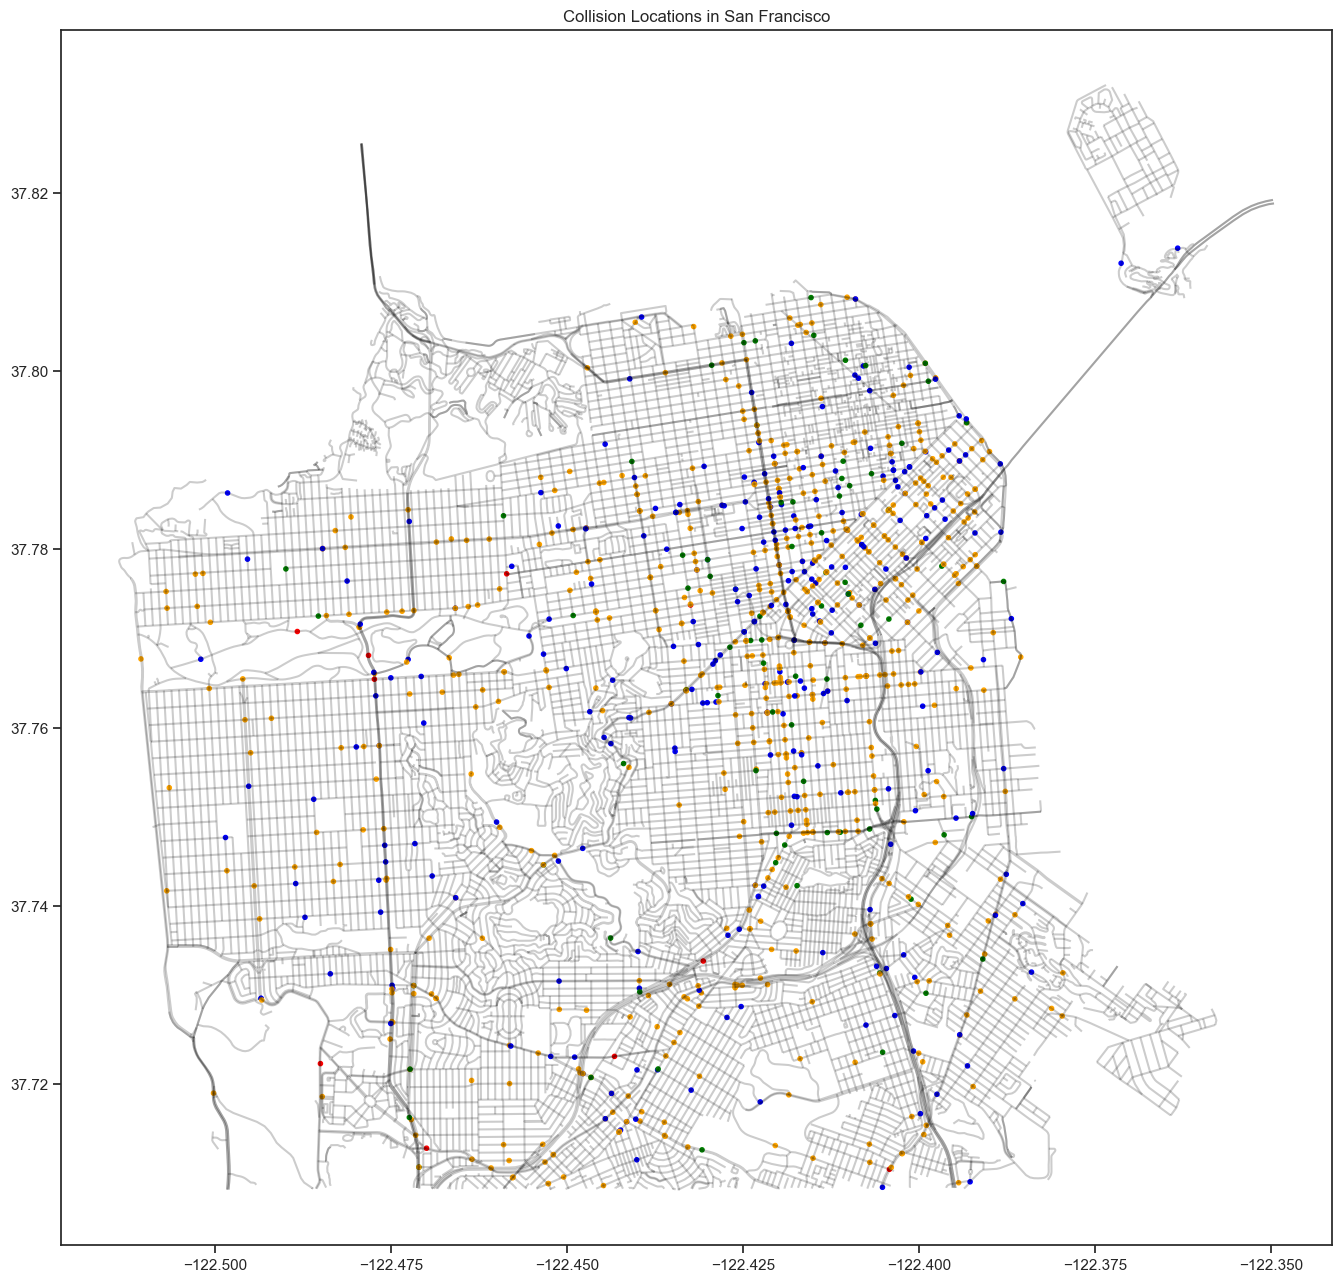

<Figure size 640x480 with 0 Axes>

In [337]:
# Initialize our plot
fig, ax = plt.subplots(figsize=(15,15))
# Plot our SF GeoDataFrame
geo_df.plot(ax=ax, alpha = .2,color = 'black')

colors = {'Injury (Complaint of Pain)':'orange', 'Injury (Severe)':'green' , 'Injury (Other Visible)':'blue','Fatal':'red'}

 
# depict illustration
plt.scatter(merged['tb_longitude'], merged['tb_latitude'], c=merged['collision_severity'].map(colors), marker = ".")
plt.title("Collision Locations in San Francisco")
plt.show()

# Turn off axis
ax.set_axis_off()
fig.tight_layout()
plt.savefig('Collision Locations in San Francisco.jpg',bbox_inches='tight')

In [338]:
merged.columns

Index(['tb_latitude', 'tb_longitude', 'collision_datetime', 'collision_date',
       'accident_year', 'month', 'day_of_week', 'primary_rd', 'weather_1',
       'collision_severity', 'road_surface', 'road_cond_1', 'lighting',
       'number_killed', 'number_injured', 'party1_type', 'total_involved',
       'main', 'description', 'temp', 'pressure', 'humidity', 'dew_point',
       'clouds', 'wind_speed', 'wind_deg', 'Hour', 'Accident_Count'],
      dtype='object')

In [339]:
merged.shape

(995, 28)

The victims involved range around 1 to 2 people with outlier of 6 for one incident. Meanwhile, the weather during these incidents tend to be wet and cold.

In [340]:
merged[['number_killed','number_injured','total_involved','temp',
       'pressure', 'humidity', 'dew_point', 'clouds', 'wind_speed', 'wind_deg']].describe()

,number_killed,number_injured,total_involved,temp,pressure,humidity,dew_point,clouds,wind_speed,wind_deg
count,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000
mean,0.009045,1.229146,1.238191,59.951467,1016.236181,79.206030,284.600683,49.492462,3.549749,235.395980
std,0.094723,0.621346,0.617117,8.343026,4.907955,14.539918,4.429974,39.475595,1.930083,83.382021
min,0.000000,0.000000,1.000000,36.608000,978.000000,10.000000,260.670000,0.000000,0.110000,0.000000
25%,0.000000,1.000000,1.000000,54.266000,1013.000000,72.000000,282.100000,5.000000,2.100000,193.500000
50%,0.000000,1.000000,1.000000,59.504000,1016.000000,82.000000,285.370000,51.000000,3.280000,267.000000
75%,0.000000,1.000000,1.000000,65.084000,1019.000000,90.000000,287.700000,93.000000,4.650000,293.000000
max,1.000000,6.000000,6.000000,89.834000,1034.000000,99.000000,292.990000,100.000000,12.340000,360.000000


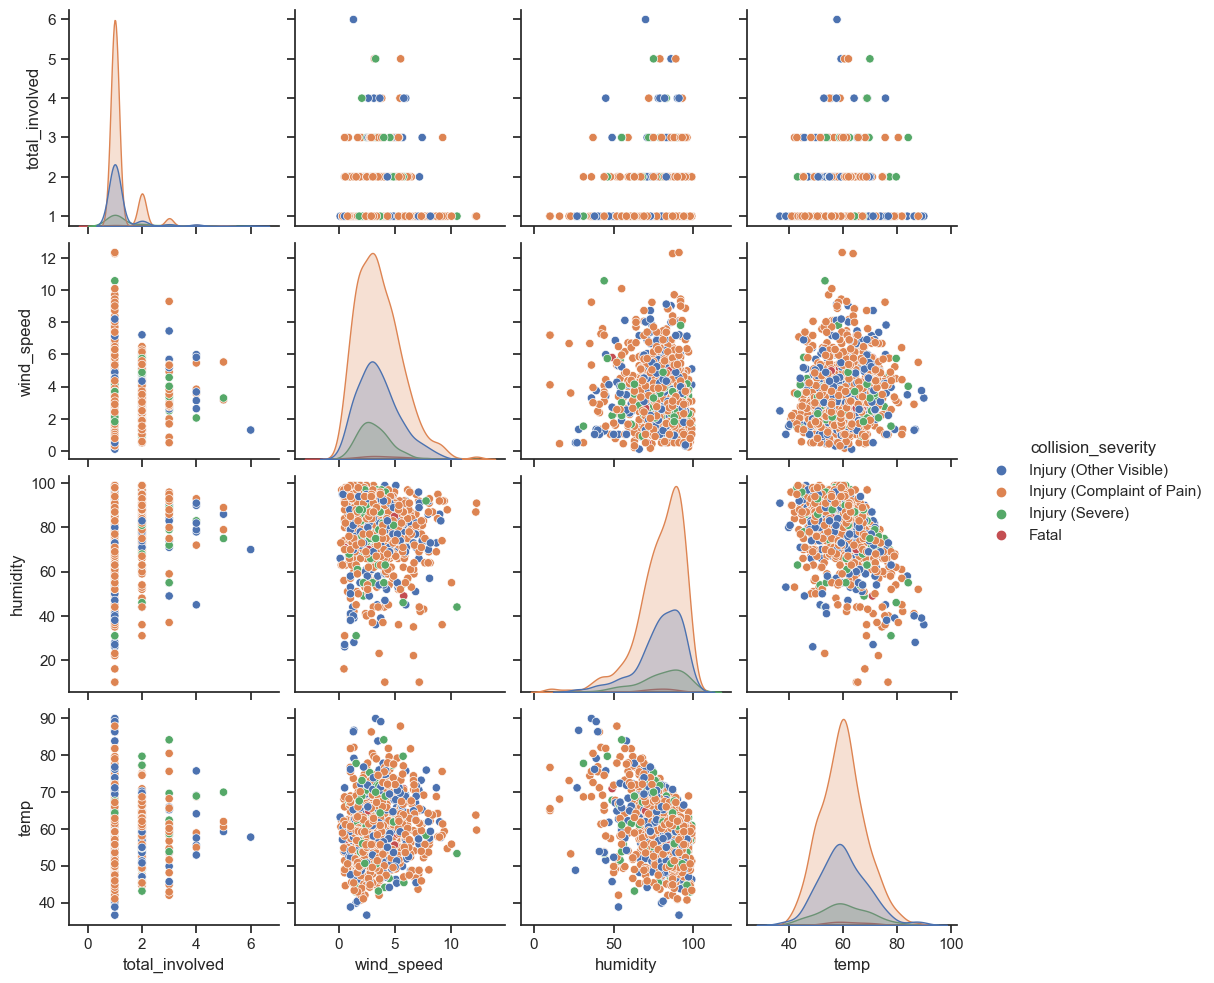

In [341]:
sns.set_theme(style="ticks")

corr = merged[['total_involved','wind_speed','humidity','temp','collision_severity']]
sns.pairplot(corr, hue = 'collision_severity' )

### Categorical Data Analysis

As seen before, the majority of collisions are moderate and happened during mostly during cool, cloudy, and very humid weather. One additional insight is that the incidents happened more to drivers, which could indicate poor road condition and visibility.

<AxesSubplot:>

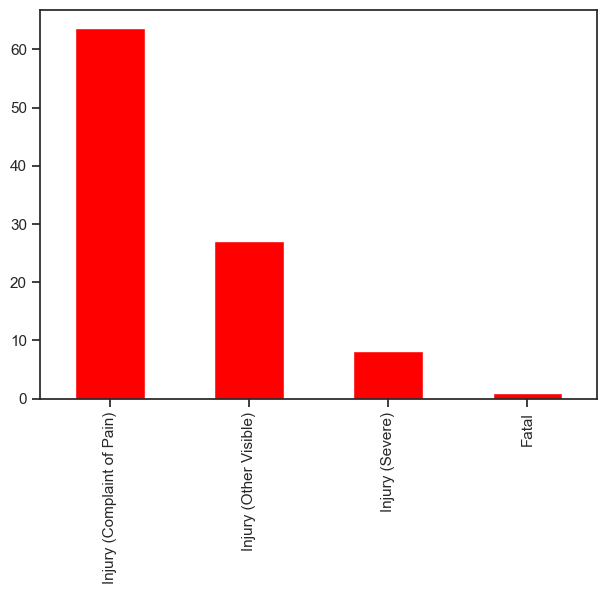

In [343]:
(merged["collision_severity"].value_counts()/merged["collision_severity"].value_counts().sum()*100).plot(kind = 'bar',color = 'red')

C:\Users\Asus\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 22.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


[Text(0, 0.5, 'Weather Parameter')]

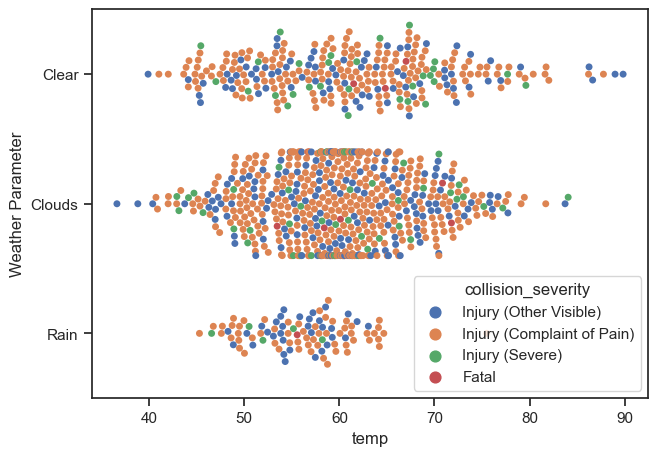

In [344]:
# Draw a categorical scatterplot to show each observation
ax = sns.swarmplot(data=merged, x="temp", y="main", hue="collision_severity")
ax.set(ylabel="Weather Parameter")

C:\Users\Asus\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 69.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


[Text(0, 0.5, 'Vehicle Type')]

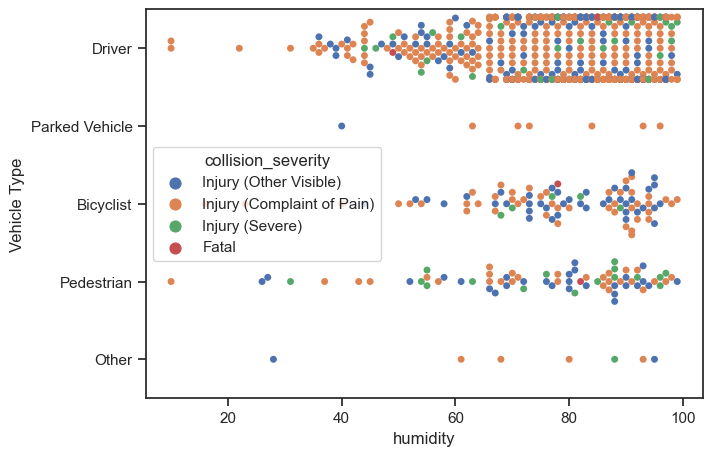

In [345]:
# Draw a categorical scatterplot to show each observation
ax = sns.swarmplot(data=merged, x="humidity", y="party1_type", hue="collision_severity")
ax.set(ylabel="Vehicle Type")

C:\Users\Asus\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 32.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


[Text(0, 0.5, 'Road Surface Condition')]

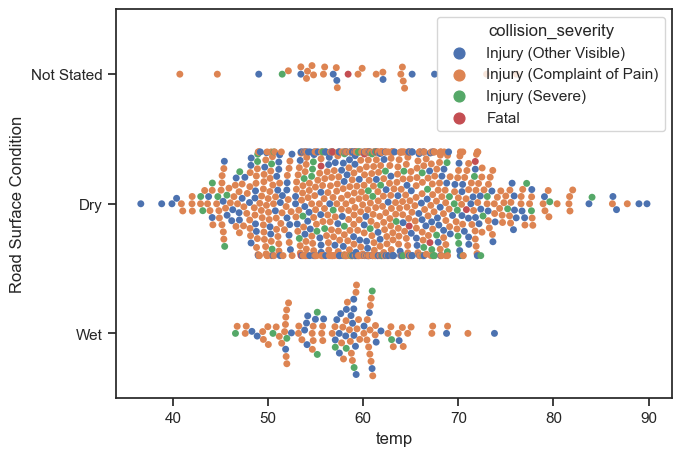

In [346]:
# Draw a categorical scatterplot to show each observation
ax = sns.swarmplot(data=merged, x="temp", y="road_surface", hue="collision_severity")
ax.set(ylabel="Road Surface Condition")

C:\Users\Asus\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 32.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Asus\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 36.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


[Text(0, 0.5, 'Lighting Condition')]

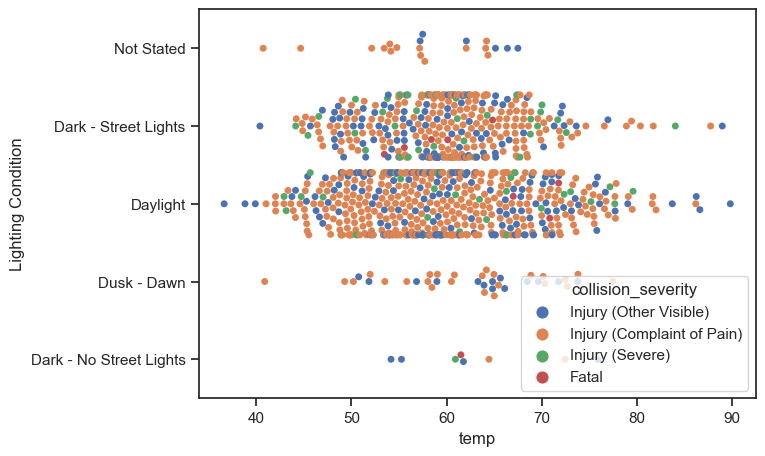

In [347]:
# Draw a categorical scatterplot to show each observation
ax = sns.swarmplot(data=merged, x="temp", y="lighting", hue="collision_severity")
ax.set(ylabel="Lighting Condition")

# Conclusion 

Contrary to previously thought, the road surface were mostly dry. But we see a division when it comes to lighting conditions between dark and daylight. This may indicate that the collisions are more likely to happen during high traffic time and/or specific months of the year. However, we can safely assume that there is some correlation between weather and the likelihood of traffic accidents. Further analysis is needed to expand on this in the future. Statisical learning model like K-mean clustering or other classifications model may be appropriate for this dataset as there are many qualitative variables.